In [12]:
## Loading libraries
import os, json, numpy as np, nibabel as nib, SimpleITK as sitk
from skimage import exposure, morphology
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown, HBox, VBox, Play, jslink, Checkbox, FloatSlider, Layout
from IPython.display import display

In [11]:
## functions utilized

def load_nifti(path):
    img = nib.load(path)
    data = img.get_fdata(dtype=np.float32)
    return data, img.affine, img.header

def save_nifti(path, data, affine, header):
    nib.Nifti1Image(data.astype(np.float32), affine, header).to_filename(path)

def sitk_from_nib(data, affine):
    # Basic conversion assuming RAS-like; for rigorous handling, use nibabel2sitk utilities.
    img = sitk.GetImageFromArray(data)  # z,y,x
    spacing = np.sqrt((affine[:3,:3] ** 2).sum(0))
    img.SetSpacing(tuple(spacing.tolist()))
    return img

def nib_from_sitk(img_sitk, reference_affine, reference_header):
    arr = sitk.GetArrayFromImage(img_sitk)
    return arr, reference_affine, reference_header

def n4_correction(data, affine, mask=None):
    img = sitk_from_nib(data, affine)
    mask_itk = sitk.OtsuThreshold(img) if mask is None else sitk.GetImageFromArray(mask.astype(np.uint8))
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected = corrector.Execute(img, mask_itk)
    return sitk.GetArrayFromImage(corrected)

def patch_denoise(data):
    img = sitk.GetImageFromArray(data)
    den = sitk.PatchBasedDenoising(img, kernelBandwidth=0.1, noiseModel=sitk.NoiseDistribution_Rician, numberOfIterations=2)
    return sitk.GetArrayFromImage(den)

def robust_zscore_within_mask(data, mask, clip=(-2.5, 5.0)):
    core = morphology.binary_erosion(mask, morphology.ball(1))
    core = core if core.sum() > 0 else mask
    vals = data[core > 0]
    m = np.median(vals)
    mad = np.median(np.abs(vals - m)) + 1e-6
    z = (data - m) / (1.4826 * mad)
    return np.clip(z, *clip)

def clahe_within_mask(data, mask, ntiles=(8,8,8), clip_limit=0.02):
    # data expected standardized roughly to [~ -3, 5]; rescale to [0,1] for CLAHE
    dmin, dmax = np.percentile(data[mask>0], (0.5, 99.5))
    scaled = (data - dmin) / (dmax - dmin + 1e-6)
    scaled = np.clip(scaled, 0, 1)
    out = np.copy(scaled)
    # apply per-slice or small 3D tiles; 3D CLAHE in skimage is limited; do per-slice robustly
    for z in range(out.shape[2]):
        if mask[..., z].any():
            out[..., z] = exposure.equalize_adapthist(out[..., z], clip_limit=clip_limit, nbins=256)
    # back to z-scored space
    out = (out - out[mask>0].mean()) / (out[mask>0].std() + 1e-6)
    data_new = np.copy(data)
    data_new[mask>0] = out[mask>0]
    return data_new

def curvature_smooth_within_mask(data, mask, iterations=3, time_step=0.0625):
    img = sitk.GetImageFromArray(data)
    msk = sitk.GetImageFromArray(mask.astype(np.uint8))
    sm = sitk.CurvatureFlow(image1=img, timeStep=time_step, numberOfIterations=iterations)
    sm_arr = sitk.GetArrayFromImage(sm)
    out = np.copy(data)
    out[mask>0] = sm_arr[mask>0]
    return out

def quick_cord_mask_guess(data):
    # VERY rough fallback: threshold top 30% + largest component per slice; replace with SCT for production
    m = np.percentile(data, 70)
    mask = data > m
    # keep central blob per slice
    for z in range(mask.shape[2]):
        lbl = morphology.label(mask[..., z])
        if lbl.max() == 0: continue
        sizes = np.bincount(lbl.ravel())
        sizes[0] = 0
        largest = sizes.argmax()
        mask[..., z] = (lbl == largest)
        mask[..., z] = morphology.binary_opening(mask[..., z], morphology.disk(1))
    mask = morphology.binary_closing(mask, morphology.ball(1))
    return mask.astype(np.uint8)

def preprocess_t2(in_path, out_dir, mask_path=None):
    os.makedirs(out_dir, exist_ok=True)
    img, aff, hdr = nib.load(in_path), None, None
    data, aff, hdr = img.get_fdata(np.float32), img.affine, img.header


def _get_slice(vol, axis, idx):
    if axis == 0:   # sagittal (x)
        sl = vol[idx, :, :]
    elif axis == 1: # coronal (y)
        sl = vol[:, idx, :]
    else:           # axial (z, default)
        sl = vol[:, :, idx]
    return np.asarray(sl)

def browse_nifti(
        vol,
        spacing=None,
        axis_default="axial",
        mask=None,
        mask_alpha=0.3,
        vmin=None,
        vmax=None,
        percentile_clip=(1, 99),
        cmap="gray"
):
    """
    Scroll through a 3D volume with a slider (optionally overlay a mask).

    Parameters
    ----------
    vol : np.ndarray
        3D array (X, Y, Z). If you passed nibabel image, use img.get_fdata().
    spacing : tuple/list of 3 floats, optional
        Voxel spacing in (dx, dy, dz). If None, aspect='equal' is used.
    axis_default : {'axial','coronal','sagittal'}
        Initial viewing axis.
    mask : np.ndarray or None
        Optional 3D binary mask (same shape as vol) to overlay.
    mask_alpha : float
        Transparency of mask overlay.
    vmin, vmax : float or None
        Intensity window. If None, computed from percentile_clip within the volume.
    percentile_clip : tuple (low, high)
        Percentiles (e.g., (1, 99)) used to compute default vmin/vmax.
    cmap : str
        Matplotlib colormap for the base image.
    """

    assert vol.ndim == 3, "vol must be a 3D array"
    if mask is not None:
        assert mask.shape == vol.shape, "mask must have same shape as vol"
        mask = mask.astype(bool)

    # default intensity window
    if vmin is None or vmax is None:
        p_low, p_high = np.percentile(vol[np.isfinite(vol)], percentile_clip)
        if vmin is None: vmin = float(p_low)
        if vmax is None: vmax = float(p_high)

    # map axis names to indices
    axis_map = {"sagittal":0, "coronal":1, "axial":2}
    axis_dd = Dropdown(options=["axial","coronal","sagittal"], value=axis_default, description="Axis:", layout=Layout(width="180px"))

    # set up slider bounds by axis
    def axis_len(ax_idx):
        return vol.shape[ax_idx]

    # play + slider
    play = Play(interval=60, value=0, min=0, max=axis_len(axis_map[axis_dd.value])-1, step=1, description="Press play")
    slider = IntSlider(value=0, min=0, max=axis_len(axis_map[axis_dd.value])-1, step=1, description='Slice:', readout=True)
    jslink((play, 'value'), (slider, 'value'))

    # optional controls
    show_mask_cb = Checkbox(value=mask is not None, description="Show mask", indent=False, layout=Layout(width="120px"))
    vmin_sl = FloatSlider(value=vmin, min=float(np.min(vol)), max=float(np.max(vol)), step=(vmax-vmin)/100 if vmax>vmin else 1.0, description='vmin', readout_format='.3g', layout=Layout(width="320px"))
    vmax_sl = FloatSlider(value=vmax, min=float(np.min(vol)), max=float(np.max(vol)), step=(vmax-vmin)/100 if vmax>vmin else 1.0, description='vmax', readout_format='.3g', layout=Layout(width="320px"))

    out = {}

    def _update_limits(*_):
        # adjust slider range when axis changes
        slider.max = axis_len(axis_map[axis_dd.value])-1
        play.max = slider.max

    axis_dd.observe(_update_limits, names='value')

    # figure
    fig, ax = plt.subplots(figsize=(5.5, 5.5))
    plt.tight_layout()

    def _aspect_for_axis(ax_name):
        # Set aspect from in-plane spacings if provided
        if spacing is None:
            return 'equal'
        dx, dy, dz = spacing
        if ax_name == "axial":     # plane = X (cols), Y (rows)
            return dx / dy if dy != 0 else 'equal'
        elif ax_name == "coronal": # plane = X (cols), Z (rows)
            return dx / dz if dz != 0 else 'equal'
        else:                      # sagittal -> Y (cols), Z (rows)
            return dy / dz if dz != 0 else 'equal'

    imshow_obj = [None]
    mask_obj = [None]

    def _draw(idx):
        ax.clear()
        ax.set_axis_off()

        ax_name = axis_dd.value
        ax_idx = axis_map[ax_name]
        sl = _get_slice(vol, ax_idx, idx)
        vvmin, vvmax = vmin_sl.value, vmax_sl.value

        # transpose for a conventional orientation (row-major)
        img2d = np.flipud(sl.T)  # simple, consistent orientation; flip if you prefer

        im = ax.imshow(img2d, cmap=cmap, vmin=vvmin, vmax=vvmax, aspect=_aspect_for_axis(ax_name))
        imshow_obj[0] = im

        title = f"{ax_name.capitalize()} | slice {idx+1}/{vol.shape[ax_idx]}"
        ax.set_title(title, fontsize=10)

        if show_mask_cb.value and mask is not None:
            msl = _get_slice(mask, ax_idx, idx).T
            msl = np.flipud(msl)
            # draw mask edges (outline) or filled overlay; here we do filled overlay
            mask_im = ax.imshow(np.ma.masked_where(~msl, msl), alpha=mask_alpha)
            mask_obj[0] = mask_im

        fig.canvas.draw_idle()

    def _on_change(change):
        if change['name'] == 'value':
            _draw(change['new'])

    slider.observe(_on_change, names='value')
    vmin_sl.observe(lambda _: _draw(slider.value), names='value')
    vmax_sl.observe(lambda _: _draw(slider.value), names='value')
    show_mask_cb.observe(lambda _: _draw(slider.value), names='value')
    axis_dd.observe(lambda _: _draw(slider.value), names='value')

    # initial draw
    _draw(slider.value)

    controls_row1 = HBox([axis_dd, play, slider])
    controls_row2 = HBox([show_mask_cb, vmin_sl, vmax_sl])
    display(VBox([controls_row1, controls_row2]))
    display(fig)

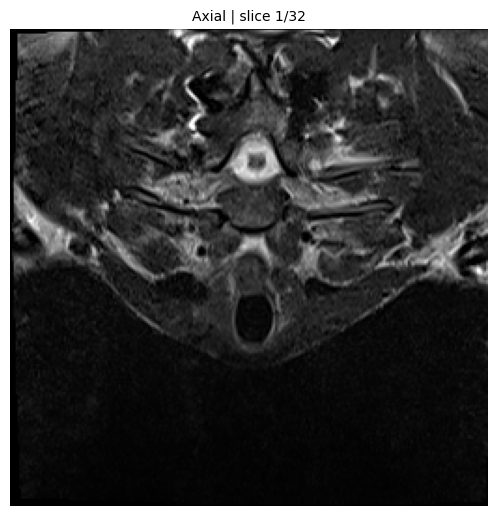

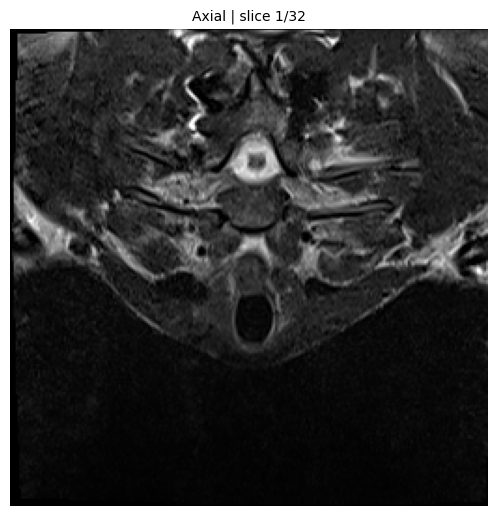

In [21]:
path2data = r"Z:\30_Oscar_Ortiz\15_SpineSeg\nnUnet\nnUNet_raw\Dataset730_SCIEMG\imagesTr"
dat_file = "SCIEMG_020_0001.nii.gz"

img = nib.load(os.path.join(path2data, dat_file))
vol = img.get_fdata().astype(float)
spacing = img.header.get_zooms()[:3]  # (dx, dy, dz)


browse_nifti(vol, spacing=spacing, axis_default="axial", mask=None)  # or mask=mask


IntSlider(value=5, description='Test', max=10)

C:\Users\ortizo\IdeaProjects\SCI_segmentation\.venv\Scripts\python.exe
ipywidgets: 8.1.7
